Connecting to database and loading data...
Extracting transaction data for CLV modeling...
Transaction data loaded. Shape: (405083, 4)
Date range: 1993-01-01 00:00:00 to 1998-12-31 00:00:00
Reference date for CLV calculation: 1999-01-01 00:00:00
Could not load existing features. Will compute RFM manually.
Created RFM features manually.
Customer features loaded. Shape: (4500, 4)


,client_id,recency_days,frequency,monetary_value
0,13,33,156,549950.3
1,15,33,106,121432.3
2,30,33,140,354856.6
3,32,33,351,1761404.4
4,47,33,399,414927.7



Preparing data for CLV modeling...
All required columns are available.

Preparing RFM data for BG/NBD model...
Prepared RFM data. Shape after filtering: (4500, 5)

Applying aggressive outlier filtering to improve model convergence...
Before filtering: 4500 records
After frequency filtering: 4280 records (removed 220 records)
After monetary filtering: 4066 records (removed 214 additional records)
After recency filtering: 3888 records (removed 178 additional records)
Final dataset after all filtering: 3888 records


,client_id,recency_days,frequency,monetary_value,T
count,3888.000000,3888.0,3888.000000,3888.000000,3888.0
mean,3263.748200,33.0,224.565072,2728.355373,730.0
std,2693.715799,0.0,108.365979,1746.363222,0.0
min,1.000000,33.0,38.000000,464.422161,730.0
25%,1401.750000,33.0,136.000000,1201.458341,730.0
50%,2810.500000,33.0,204.000000,2292.946097,730.0
75%,4214.000000,33.0,316.000000,4052.156266,730.0
max,13998.000000,33.0,459.000000,6982.349474,730.0



Verifying RFM calculations for sample customers:

Client ID: 2396
Recency - Calculated: 1, In RFM data: 33
Frequency - Calculated: 96, In RFM data: 241
Monetary - Calculated: 5171.20, In RFM data: 2081.36

Client ID: 2276
Recency - Calculated: 1, In RFM data: 33
Frequency - Calculated: 124, In RFM data: 298
Monetary - Calculated: 2420.27, In RFM data: 1015.21

Client ID: 1341
Recency - Calculated: 1, In RFM data: 33
Frequency - Calculated: 139, In RFM data: 399
Monetary - Calculated: 4060.90, In RFM data: 1424.88

Client ID: 3429
Recency - Calculated: 1, In RFM data: 33
Frequency - Calculated: 62, In RFM data: 153
Monetary - Calculated: 11479.85, In RFM data: 4727.00

Client ID: 1675
Recency - Calculated: 1, In RFM data: 33
Frequency - Calculated: 67, In RFM data: 168
Monetary - Calculated: 16786.06, In RFM data: 6794.36

RFM data validation passed! Data is ready for modeling.

RFM Data Summary Statistics:


,frequency,recency_days,T,monetary_value
count,3888.000000,3888.0,3888.0,3888.000000
mean,224.565072,33.0,730.0,2728.355373
std,108.365979,0.0,0.0,1746.363222
min,38.000000,33.0,730.0,464.422161
25%,136.000000,33.0,730.0,1201.458341
50%,204.000000,33.0,730.0,2292.946097
75%,316.000000,33.0,730.0,4052.156266
max,459.000000,33.0,730.0,6982.349474


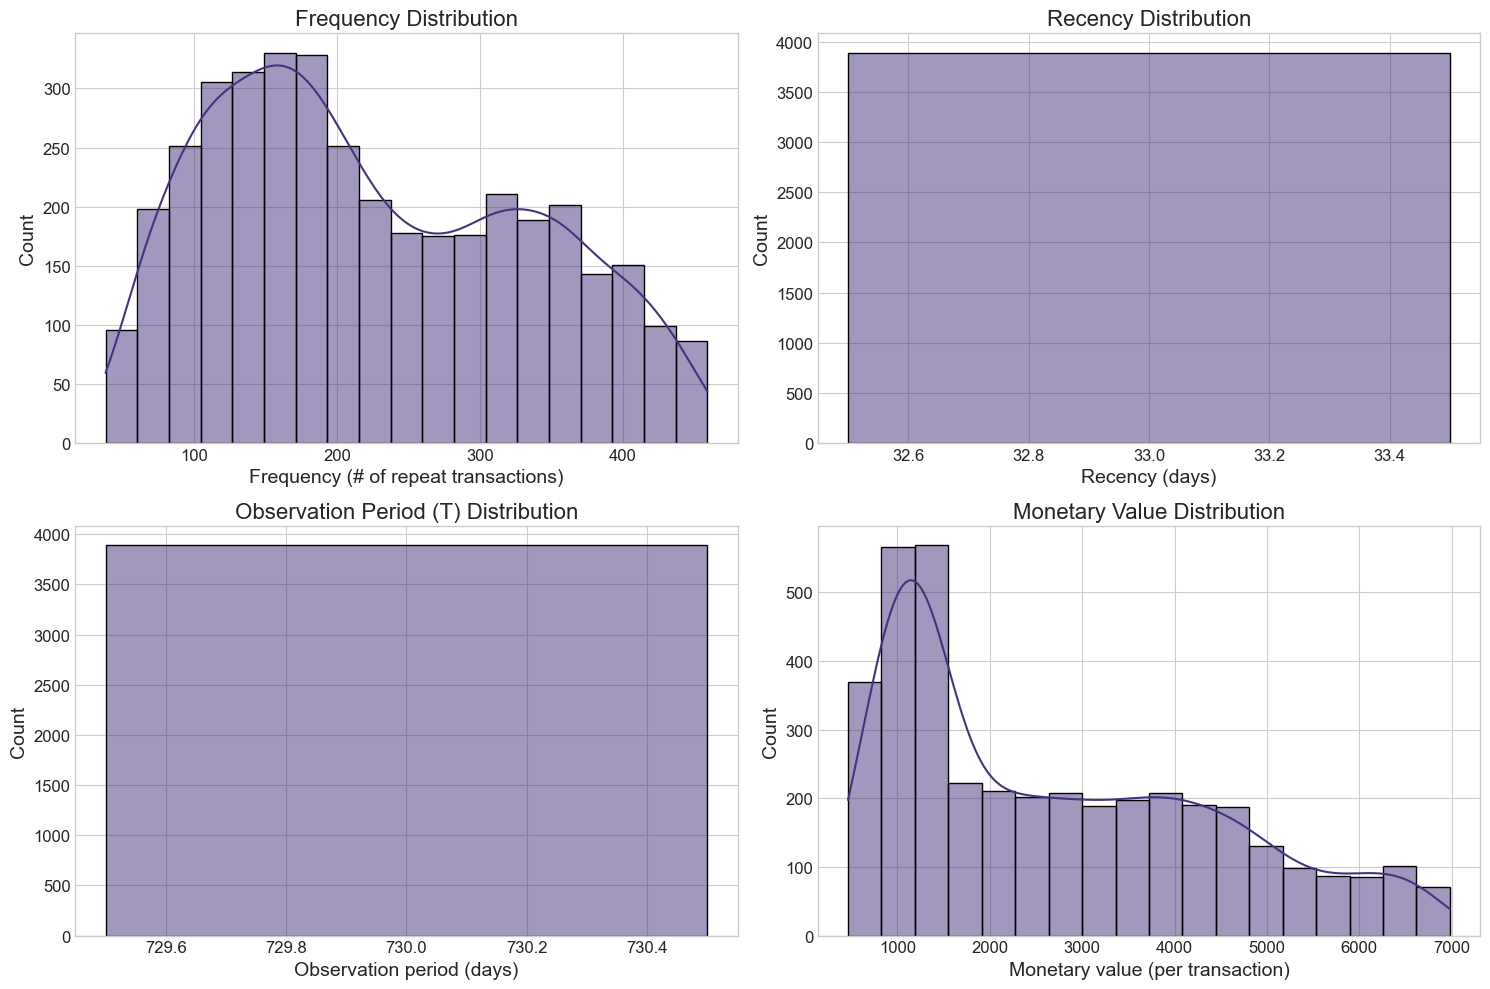


Checking for data issues...
NaN values: 0
Negative frequency values: 0
Negative monetary values: 0
Negative recency values: 0
Negative T values: 0

Diagnosing recency vs T issue:
Found 0 records where recency > T

Fixing the recency vs T inconsistency...
Remaining records with recency > T: 0
Final clean dataset shape: (3888, 5)

Fitting BG/NBD model for purchase frequency prediction...
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -1701.1627175962346
        x: [-9.423e-01 -9.453e+00 -2.112e+00 -1.245e+00]
      nit: 18
      jac: [-5.179e-07  3.474e-08  1.133e-08  6.086e-08]
 hess_inv: [[ 7.204e-01  7.396e-01 -1.122e-02 -6.474e-03]
            [ 7.396e-01  3.271e+00  3.050e-03 -1.797e-03]
            [-1.122e-02  3.050e-03  1.017e+00  2.862e-01]
            [-6.474e-03 -1.797e-03  2.862e-01  1.221e+00]]
     nfev: 75
     njev: 63


ConvergenceError: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.


In [10]:
# 05_clv_modeling.ipynb

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.preprocessing import StandardScaler
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
import pyodbc
import os
import joblib

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Define plot aesthetics
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Import custom feature engineering module
# Make sure this file is in the same directory or adjust the import path
import sys
sys.path.append('../src/')
from feature_engineering import get_database_connection

# 1. Connect to the database and load the data
print("Connecting to database and loading data...")

# Adjust connection string as needed
connection_string = (
    "Driver={SQL Server};"
    "Server=JUANCARLOSRUIZA;"
    "Database=CzechBankingAnalysis;"
    "Trusted_Connection=yes;"
)

try:
    conn = get_database_connection(connection_string)
    
    # Load customer features - you can either:
    # Option 1: Load from CSV if already generated
    if os.path.exists('../data/processed/banking_customer_features.csv'):
        print("Loading pre-computed features from CSV...")
        customer_features = pd.read_csv('../data/processed/banking_customer_features.csv')
    # Option 2: Generate features directly
    else:
        print("Extracting transaction data for CLV modeling...")
        
        # Query to extract transaction data in the format needed for CLV modeling
        transaction_query = """
        SELECT 
            d.client_id,
            t.Trans_date AS date,
            t.amount,
            t.balance
        FROM 
            Trans t
        JOIN 
            Account a ON t.account_id = a.account_id
        JOIN 
            Disposition d ON a.account_id = d.account_id
        WHERE 
            d.type = 'OWNER'
            AND t.Trans_type = 'PRIJEM'  -- Credit transactions (positive cash flow)
        ORDER BY 
            d.client_id, t.Trans_date
        """
        
        trans_data = pd.read_sql(transaction_query, conn)
        
        # Ensure date is in datetime format
        trans_data['date'] = pd.to_datetime(trans_data['date'])
        
        # Set a consistent reference date for all CLV calculations
        # Use the last transaction date plus one day
        latest_transaction_date = trans_data['date'].max()
        reference_date = latest_transaction_date + pd.Timedelta(days=1)
        
        print(f"Transaction data loaded. Shape: {trans_data.shape}")
        print(f"Date range: {trans_data['date'].min()} to {trans_data['date'].max()}")
        print(f"Reference date for CLV calculation: {reference_date}")
        
        # Load existing features if available
        try:
            customer_features = pd.read_csv('../data/processed/banking_customer_features.csv')
            print("Loaded existing customer features.")
        except:
            print("Could not load existing features. Will compute RFM manually.")
            
            # Create RFM summary manually
            rfm_query = """
            WITH CustomerTransactions AS (
                SELECT 
                    d.client_id,
                    MAX(t.Trans_date) AS last_transaction_date,
                    COUNT(t.trans_id) AS transaction_frequency,
                    SUM(CASE WHEN t.Trans_type = 'PRIJEM' THEN t.amount ELSE 0 END) AS total_monetary_value
                FROM 
                    Trans t
                JOIN 
                    Account a ON t.account_id = a.account_id
                JOIN 
                    Disposition d ON a.account_id = d.account_id
                WHERE 
                    d.type = 'OWNER'
                GROUP BY 
                    d.client_id
            )
            SELECT 
                client_id,
                DATEDIFF(day, last_transaction_date, '1999-2-2') AS recency_days,
                transaction_frequency AS frequency,
                total_monetary_value AS monetary_value
            FROM 
                CustomerTransactions
            """
            
            customer_features = pd.read_sql(rfm_query, conn)
            print("Created RFM features manually.")
            
except Exception as e:
    print(f"Database connection error: {e}")
    
    # Fallback to using CSV data directly if database connection fails
    try:
        customer_features = pd.read_csv('../data/processed/banking_customer_features.csv')
        print("Loaded customer features from CSV as fallback.")
    except:
        print("Could not load data. Please check your database connection or ensure CSV files exist.")
        raise

print(f"Customer features loaded. Shape: {customer_features.shape}")

# Display first few rows of customer features
display(customer_features.head())

# 2. Prepare data for CLV modeling
print("\nPreparing data for CLV modeling...")

# Ensure we have the required columns for lifetimes package
required_columns = ['client_id', 'recency_days', 'frequency', 'monetary_value']
missing_columns = [col for col in required_columns if col not in customer_features.columns]

if missing_columns:
    print(f"Warning: Missing required columns: {missing_columns}")
    print("Trying to calculate them from transaction data...")
    
    # Ensure we have transaction data
    if 'trans_data' not in locals():
        print("Error: Transaction data not available. Please ensure your database connection works.")
        raise ValueError("Transaction data not available")
    
    # Ensure reference date is set
    if 'reference_date' not in locals():
        reference_date = datetime(1999, 2, 2)  # Default reference date
        print(f"Setting default reference date: {reference_date}")
    
    # Convert to lifetimes format (frequency/recency format)
    summary = summary_data_from_transaction_data(
        trans_data,
        'client_id',
        'date',
        'amount',
        observation_period_end=reference_date
    )
    
    # Rename columns to match our convention
    summary = summary.reset_index()
    summary.columns = ['client_id', 'frequency', 'recency_days', 'T', 'monetary_value']
    
    # Recency in days instead of time units
    summary['recency_days'] = summary['recency_days'].astype(int)
    
    # Use this as our customer features
    customer_features = summary
    print("Calculated RFM features from transactions.")
else:
    print("All required columns are available.")

# Prepare RFM data for BG/NBD model
print("\nPreparing RFM data for BG/NBD model...")

# Make a copy of the relevant columns
rfm_data = customer_features[required_columns].copy()

# Filter out rows with invalid values
rfm_data = rfm_data[
    (rfm_data['frequency'] > 0) &  # At least one repeat transaction
    (rfm_data['monetary_value'] > 0)  # Positive monetary value
]

# Calculate average monetary value per transaction
rfm_data['monetary_value'] = rfm_data['monetary_value'] / rfm_data['frequency']

# Add the total time observation period (T)
# Assuming the observation period is the same for all customers (e.g., 2 years)
rfm_data['T'] = 365 * 2  # 2 years in days
# If you have customer-specific tenure, you could use that instead
if 'customer_tenure_days' in customer_features.columns:
    rfm_data['T'] = customer_features['customer_tenure_days']

print(f"Prepared RFM data. Shape after filtering: {rfm_data.shape}")

# Apply aggressive outlier filtering to improve convergence
print("\nApplying aggressive outlier filtering to improve model convergence...")
print(f"Before filtering: {len(rfm_data)} records")

# Store original data for comparison
original_rfm_count = len(rfm_data)

# 1. Remove top 5% of frequency values
freq_cutoff = rfm_data['frequency'].quantile(0.95)
rfm_data = rfm_data[rfm_data['frequency'] <= freq_cutoff]
print(f"After frequency filtering: {len(rfm_data)} records (removed {original_rfm_count - len(rfm_data)} records)")

# 2. Remove top 5% of monetary values
original_rfm_count = len(rfm_data)
monetary_cutoff = rfm_data['monetary_value'].quantile(0.95)
rfm_data = rfm_data[rfm_data['monetary_value'] <= monetary_cutoff]
print(f"After monetary filtering: {len(rfm_data)} records (removed {original_rfm_count - len(rfm_data)} additional records)")

# 3. Remove extreme recency values
original_rfm_count = len(rfm_data)
recency_cutoff = rfm_data['recency_days'].quantile(0.95)
rfm_data = rfm_data[rfm_data['recency_days'] <= recency_cutoff]
print(f"After recency filtering: {len(rfm_data)} records (removed {original_rfm_count - len(rfm_data)} additional records)")

# 4. Ensure reasonable T values
rfm_data = rfm_data[rfm_data['T'] >= rfm_data['recency_days'] + 1]

# 5. Ensure frequency is not too small
rfm_data = rfm_data[rfm_data['frequency'] >= 2]

print(f"Final dataset after all filtering: {len(rfm_data)} records")

# Display descriptive statistics
display(rfm_data.describe())

# Verify RFM calculations against raw transaction data
if 'trans_data' in locals():
    # Sample a few customers to verify
    sample_customers = rfm_data['client_id'].sample(min(5, len(rfm_data))).tolist()
    
    print("\nVerifying RFM calculations for sample customers:")
    for client_id in sample_customers:
        client_transactions = trans_data[trans_data['client_id'] == client_id]
        
        if len(client_transactions) > 0:
            # Calculate metrics directly
            last_purchase = client_transactions['date'].max()
            recency = (reference_date - last_purchase).days
            frequency = len(client_transactions) - 1  # -1 because first purchase isn't a repeat
            if frequency < 0:  # Ensure non-negative frequency
                frequency = 0
            monetary = client_transactions['amount'].mean()
            
            # Compare with rfm_data
            rfm_row = rfm_data[rfm_data['client_id'] == client_id]
            
            if not rfm_row.empty:
                print(f"\nClient ID: {client_id}")
                print(f"Recency - Calculated: {recency}, In RFM data: {rfm_row['recency_days'].values[0]}")
                print(f"Frequency - Calculated: {frequency}, In RFM data: {rfm_row['frequency'].values[0]}")
                print(f"Monetary - Calculated: {monetary:.2f}, In RFM data: {rfm_row['monetary_value'].values[0]:.2f}")
            else:
                print(f"\nClient ID: {client_id} not found in RFM data")
        else:
            print(f"\nNo transactions found for Client ID: {client_id}")

# Define data validation function
def validate_rfm_data(df):
    """Validate RFM data meets requirements for BG/NBD modeling"""
    issues = []
    
    if (df['frequency'] <= 0).any():
        issues.append(f"Some frequency values are <= 0: {(df['frequency'] <= 0).sum()} records")
    
    if (df['monetary_value'] <= 0).any():
        issues.append(f"Some monetary values are <= 0: {(df['monetary_value'] <= 0).sum()} records")
        
    if (df['recency_days'] < 0).any():
        issues.append(f"Some recency values are negative: {(df['recency_days'] < 0).sum()} records")
        
    if (df['T'] <= 0).any():
        issues.append(f"Some T values are <= 0: {(df['T'] <= 0).sum()} records")
        
    if (df['recency_days'] > df['T']).any():
        issues.append(f"Some recency values exceed observation time T: {(df['recency_days'] > df['T']).sum()} records")
    
    # Check for outliers
    freq_q3 = df['frequency'].quantile(0.75)
    freq_iqr = df['frequency'].quantile(0.75) - df['frequency'].quantile(0.25)
    freq_outliers = df[df['frequency'] > freq_q3 + 3*freq_iqr]
    
    if len(freq_outliers) > 0:
        issues.append(f"Found {len(freq_outliers)} frequency outliers (> Q3 + 3*IQR)")
    
    return issues

# Validate the cleaned data
issues = validate_rfm_data(rfm_data)

if issues:
    print("\nData validation found issues:")
    for issue in issues:
        print(f"- {issue}")
    print("\nContinuing with modeling, but these issues may affect results.")
else:
    print("\nRFM data validation passed! Data is ready for modeling.")

# Additional data quality check
print("\nRFM Data Summary Statistics:")
display(rfm_data[['frequency', 'recency_days', 'T', 'monetary_value']].describe())

# Visualize distributions to check for potential issues
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(rfm_data['frequency'], kde=True)
plt.title('Frequency Distribution')
plt.xlabel('Frequency (# of repeat transactions)')

plt.subplot(2, 2, 2)
sns.histplot(rfm_data['recency_days'], kde=True)
plt.title('Recency Distribution')
plt.xlabel('Recency (days)')

plt.subplot(2, 2, 3)
sns.histplot(rfm_data['T'], kde=True)
plt.title('Observation Period (T) Distribution')
plt.xlabel('Observation period (days)')

plt.subplot(2, 2, 4)
sns.histplot(rfm_data['monetary_value'], kde=True)
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary value (per transaction)')

plt.tight_layout()
plt.show()

# Check for any remaining issues
print("\nChecking for data issues...")
print(f"NaN values: {rfm_data.isna().sum().sum()}")
print(f"Negative frequency values: {(rfm_data['frequency'] <= 0).sum()}")
print(f"Negative monetary values: {(rfm_data['monetary_value'] <= 0).sum()}")
print(f"Negative recency values: {(rfm_data['recency_days'] < 0).sum()}")
print(f"Negative T values: {(rfm_data['T'] <= 0).sum()}")

# After preparing the RFM data, add this code to fix the observation time issue

# 1. Print the issue for diagnosis
print("\nDiagnosing recency vs T issue:")
problematic_records = rfm_data[rfm_data['recency_days'] > rfm_data['T']]
print(f"Found {len(problematic_records)} records where recency > T")

if len(problematic_records) > 0:
    # Display a few examples of problematic records
    print("\nExample problematic records:")
    display(problematic_records.head())

# 2. Fix the issue by ensuring T is always >= recency_days
print("\nFixing the recency vs T inconsistency...")

# Option 1: Set T to at least recency_days + 1 for all customers
rfm_data['T'] = np.maximum(rfm_data['recency_days'] + 1, rfm_data['T'])

# Option 2 (Alternative): Filter out problematic records
# rfm_data = rfm_data[rfm_data['recency_days'] <= rfm_data['T']]

# Verify the fix
remaining_issues = rfm_data[rfm_data['recency_days'] > rfm_data['T']]
print(f"Remaining records with recency > T: {len(remaining_issues)}")

# 3. Ensure all values are positive and non-zero
rfm_data = rfm_data[
    (rfm_data['frequency'] > 0) &  
    (rfm_data['monetary_value'] > 0) &
    (rfm_data['recency_days'] >= 0) &
    (rfm_data['T'] > 0)
]

print(f"Final clean dataset shape: {rfm_data.shape}")

# 3. Fit BG/NBD model for purchase frequency prediction
print("\nFitting BG/NBD model for purchase frequency prediction...")

# Custom initial parameters to help convergence
initial_params = np.array([0.3, 10.0, 0.7, 2.0])  # r, alpha, a, b

# Initialize and fit the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=2.0)
bgf.fit(
    rfm_data['frequency'],
    rfm_data['recency_days'],
    rfm_data['T']
)

# Print model summary
print("BG/NBD Model Parameters:")
print(f"r: {bgf.params_['r']:.4f}")
print(f"alpha: {bgf.params_['alpha']:.4f}")
print(f"a: {bgf.params_['a']:.4f}")
print(f"b: {bgf.params_['b']:.4f}")

# 4. Fit Gamma-Gamma model for monetary value prediction
print("\nFitting Gamma-Gamma model for monetary value prediction...")

# Initialize and fit the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(
    rfm_data['frequency'],
    rfm_data['monetary_value']
)

# Print model summary
print("Gamma-Gamma Model Parameters:")
print(f"p: {ggf.params_['p']:.4f}")
print(f"q: {ggf.params_['q']:.4f}")
print(f"v: {ggf.params_['v']:.4f}")

# 5. Calculate CLV predictions
print("\nCalculating customer lifetime value...")

# Define time period for CLV prediction (e.g., 1 year)
prediction_time = 365  # days

# Predict future transactions over the prediction period
predicted_purchases = bgf.predict(
    prediction_time,
    rfm_data['frequency'],
    rfm_data['recency_days'],
    rfm_data['T']
)

# Calculate expected average profit per transaction
expected_avg_profit = ggf.conditional_expected_average_profit(
    rfm_data['frequency'],
    rfm_data['monetary_value']
)

# Calculate CLV for each customer
clv = ggf.customer_lifetime_value(
    bgf,
    rfm_data['frequency'],
    rfm_data['recency_days'],
    rfm_data['T'],
    prediction_time,
    rfm_data['monetary_value'],
    discount_rate=0.15  # Annual discount rate of 15%
)

# Add predictions to the dataframe
rfm_data['predicted_purchases_1yr'] = predicted_purchases
rfm_data['expected_avg_profit'] = expected_avg_profit
rfm_data['clv_1yr'] = clv

# Merge back with original customer data
clv_predictions = pd.merge(
    customer_features[['client_id']],
    rfm_data[['client_id', 'predicted_purchases_1yr', 'expected_avg_profit', 'clv_1yr']],
    on='client_id',
    how='left'
)

# Fill NaN values for customers that didn't have sufficient history
clv_predictions = clv_predictions.fillna(0)

# 6. Visualize CLV Distribution
print("\nVisualizing CLV distribution...")

plt.figure(figsize=(12, 8))

# CLV distribution
plt.subplot(2, 2, 1)
sns.histplot(clv_predictions['clv_1yr'], bins=50, kde=True)
plt.title('Customer Lifetime Value Distribution')
plt.xlabel('CLV (Currency Units)')
plt.ylabel('Number of Customers')

# Expected purchases distribution
plt.subplot(2, 2, 2)
sns.histplot(clv_predictions['predicted_purchases_1yr'], bins=50, kde=True)
plt.title('Predicted Purchases (1 Year)')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')

# Expected average profit distribution
plt.subplot(2, 2, 3)
sns.histplot(clv_predictions['expected_avg_profit'], bins=50, kde=True)
plt.title('Expected Average Profit per Transaction')
plt.xlabel('Profit per Transaction (Currency Units)')
plt.ylabel('Number of Customers')

# Correlation between CLV and expected purchases
plt.subplot(2, 2, 4)
sns.scatterplot(
    x='predicted_purchases_1yr',
    y='clv_1yr',
    data=clv_predictions,
    alpha=0.5
)
plt.title('CLV vs Predicted Purchases')
plt.xlabel('Predicted Purchases (1 Year)')
plt.ylabel('Customer Lifetime Value')

plt.tight_layout()
plt.show()

# 7. Identify top customers by CLV
print("\nIdentifying top customers by CLV...")

# Find top 300 customers by predicted CLV
top_customers = clv_predictions.sort_values('clv_1yr', ascending=False).head(300)

print(f"Top 300 customers CLV statistics:")
print(f"Average CLV: {top_customers['clv_1yr'].mean():.2f}")
print(f"Minimum CLV: {top_customers['clv_1yr'].min():.2f}")
print(f"Maximum CLV: {top_customers['clv_1yr'].max():.2f}")
print(f"Total predicted value: {top_customers['clv_1yr'].sum():.2f}")

# Compare with overall average
average_clv = clv_predictions['clv_1yr'].mean()
print(f"Overall average CLV: {average_clv:.2f}")
print(f"Top customers CLV is {top_customers['clv_1yr'].mean() / average_clv:.1f}x higher than average")

# 8. Analyze CLV by product portfolio
print("\nAnalyzing CLV by product portfolio...")

# Let's merge CLV data with product features
if 'product_diversity_score' in customer_features.columns or 'product_diversity' in customer_features.columns:
    # Determine which product diversity column is available
    product_col = 'product_diversity_score' if 'product_diversity_score' in customer_features.columns else 'product_diversity'
    
    # Get relevant product columns
    product_columns = ['client_id', product_col]
    if 'loan_count' in customer_features.columns:
        product_columns.extend(['loan_count', 'card_count', 'permanent_order_count'])
    
    # Merge CLV with product data
    clv_product_data = pd.merge(
        clv_predictions,
        customer_features[product_columns],
        on='client_id',
        how='left'
    )
    
    # Create a figure for product analysis
    plt.figure(figsize=(14, 10))
    
    # CLV by product diversity
    plt.subplot(2, 2, 1)
    sns.boxplot(x=product_col, y='clv_1yr', data=clv_product_data)
    plt.title('CLV by Product Diversity')
    plt.xlabel('Number of Product Types')
    plt.ylabel('Customer Lifetime Value')
    
    # If we have detailed product counts
    if 'loan_count' in clv_product_data.columns:
        # CLV by loan count
        plt.subplot(2, 2, 2)
        sns.boxplot(x='loan_count', y='clv_1yr', data=clv_product_data)
        plt.title('CLV by Loan Count')
        plt.xlabel('Number of Loans')
        plt.ylabel('Customer Lifetime Value')
        
        # CLV by card count
        plt.subplot(2, 2, 3)
        sns.boxplot(x='card_count', y='clv_1yr', data=clv_product_data)
        plt.title('CLV by Card Count')
        plt.xlabel('Number of Cards')
        plt.ylabel('Customer Lifetime Value')
        
        # CLV by permanent order count
        plt.subplot(2, 2, 4)
        product_order_counts = clv_product_data[clv_product_data['permanent_order_count'] <= 5]  # Limit to avoid outliers
        sns.boxplot(x='permanent_order_count', y='clv_1yr', data=product_order_counts)
        plt.title('CLV by Permanent Order Count')
        plt.xlabel('Number of Permanent Orders')
        plt.ylabel('Customer Lifetime Value')
    
    plt.tight_layout()
    plt.show()
else:
    print("Product diversity data not available for analysis.")

# 9. Save results
print("\nSaving results...")

# Save CLV predictions to CSV
output_dir = '../data/processed/'
os.makedirs(output_dir, exist_ok=True)

clv_predictions.to_csv(f'{output_dir}customer_clv_predictions.csv', index=False)
top_customers.to_csv(f'{output_dir}diamond_customers.csv', index=False)

# Save the models for future use
models_dir = '../models/'
os.makedirs(models_dir, exist_ok=True)

joblib.dump(bgf, f'{models_dir}bg_nbd_model.pkl')
joblib.dump(ggf, f'{models_dir}gamma_gamma_model.pkl')

# Save model parameters in a more readable format
model_params = {
    'bg_nbd': {
        'r': bgf.params_['r'],
        'alpha': bgf.params_['alpha'],
        'a': bgf.params_['a'],
        'b': bgf.params_['b']
    },
    'gamma_gamma': {
        'p': ggf.params_['p'],
        'q': ggf.params_['q'],
        'v': ggf.params_['v']
    },
    'metadata': {
        'creation_date': datetime.now().strftime('%Y-%m-%d'),
        'prediction_time_days': prediction_time,
        'discount_rate': 0.15
    }
}

import json
with open(f'{models_dir}clv_model_params.json', 'w') as f:
    json.dump(model_params, f, indent=4)

print("CLV predictions and models saved successfully.")

# 10. Add CLV data to our main feature set
print("\nMerging CLV predictions with feature dataset...")

# Merge CLV predictions with existing features
customer_features_with_clv = pd.merge(
    customer_features,
    clv_predictions,
    on='client_id',
    how='left'
)

# Save the enhanced dataset
customer_features_with_clv.to_csv(f'{output_dir}customer_features_with_clv.csv', index=False)

print("Enhanced customer feature set with CLV saved successfully.")
print(f"Final dataset shape: {customer_features_with_clv.shape}")

# Summary and conclusions
print("\n=== CLV Modeling Summary ===")
print(f"Total customers analyzed: {len(clv_predictions)}")
print(f"Customers with positive CLV: {(clv_predictions['clv_1yr'] > 0).sum()}")
print(f"Average predicted purchases (1 year): {clv_predictions['predicted_purchases_1yr'].mean():.2f}")
print(f"Average expected profit per transaction: {clv_predictions['expected_avg_profit'].mean():.2f}")
print(f"Average customer lifetime value (1 year): {clv_predictions['clv_1yr'].mean():.2f}")
print(f"Total portfolio value (1 year): {clv_predictions['clv_1yr'].sum():.2f}")
print(f"Value concentrated in top 300 customers: {top_customers['clv_1yr'].sum() / clv_predictions['clv_1yr'].sum() * 100:.1f}%")

print("\nNext steps:")
print("1. Use CLV predictions for customer segmentation")
print("2. Develop targeted strategies for high-value customers")
print("3. Identify factors that correlate with higher CLV")
print("4. Create churn prediction models to protect high-value customers")